In [1]:
import os
import FlowCytometryTools as fct
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
batch_date = '02_07_20'
fcs_locs = "/Volumes/KeithSSD/RockCreek/RC_CellCounts/data/Pooled_Runs"
fcs_files = os.listdir(fcs_locs)
dates_tubes = [[f[:8].replace("_","-"), f[9:-4], f] for f in fcs_files if batch_date in f]
file_table = pd.DataFrame(data=dates_tubes, columns=['proc_date', 'Tube', 'fileName'])
file_table['pathName'] = file_table['fileName'].apply(lambda x: os.path.join(fcs_locs, x))
assert len(file_table['Tube'].unique()) == len(file_table['Tube'])
print("{} files detected, {} selected from {}".format(len(fcs_files), len(file_table), batch_date))
file_table.head()

193 files detected, 52 selected from 02_07_20


,proc_date,Tube,fileName,pathName
0,02-07-20,JustWater,02_07_20_JustWater.fcs,/Volumes/KeithSSD/RockCreek/RC_CellCounts/data...
1,02-07-20,Tube_1,02_07_20_Tube_1.fcs,/Volumes/KeithSSD/RockCreek/RC_CellCounts/data...
2,02-07-20,Tube_2,02_07_20_Tube_2.fcs,/Volumes/KeithSSD/RockCreek/RC_CellCounts/data...
3,02-07-20,Tube_3,02_07_20_Tube_3.fcs,/Volumes/KeithSSD/RockCreek/RC_CellCounts/data...
4,02-07-20,Tube_4,02_07_20_Tube_4.fcs,/Volumes/KeithSSD/RockCreek/RC_CellCounts/data...


In [3]:
def pull_relavent_metadata(x):
    meta = x.get_meta()
    _channels_ = meta['_channels_'].copy()
    voltages = _channels_[_channels_['$PnN'].str.endswith("-A")].set_index('$PnN')['$PnV'].to_dict()
    voltages = {i[:-2]+' gain':j for i, j in voltages.items()}
    voltages['startTime'] = meta['$BTIM']
    voltages['endTime'] = meta['$ETIM']
    return voltages

In [4]:
other_channels = ['Time']
measured_channels = ["FSC-A", "SSC-A", "488 530/30-A", "488 585/42-A", "488 670LP-A",
                    "488 780/60-A", "633 660/20-A", "633 780/60-A"]
b_value = 400
data_mats, meta_datas = {}, {}
for tn, pn in file_table[['Tube', 'pathName']].values:
    print("Reading {}     ".format(tn), sep=' ', end='\r', flush=True)
    
    data_obj = fct.FCMeasurement(ID=tn, datafile=pn)
    temp_df1 = data_obj.data[measured_channels + other_channels]
    temp_df2 = temp_df1.copy()
    for ch_ in measured_channels:
        temp_df2[ch_] = data_obj.transform('hlog', channels=[ch_], b=b_value).data[ch_]
        if tn == 'Tube_10':
            min_, q1_, med_, q3_, max_ = np.percentile(temp_df1[ch_].values, [0, 25, 50, 75, 100])
            print("Pre-transform {}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}".format(ch_, min_, q1_, med_, q3_, max_))
            min_, q1_, med_, q3_, max_ = np.percentile(temp_df2[ch_].values, [0, 25, 50, 75, 100])
            print("Post {}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}".format(ch_, min_, q1_, med_, q3_, max_))

    data_mats[tn] = temp_df2.copy()    
    meta_datas[tn] = pull_relavent_metadata(data_obj)

Pre-transform FSC-A	-334.05	-39.10	11.90	92.65	262143.00
Post FSC-A	-1515.29	-179.24	54.58	424.25	9993.35
Pre-transform SSC-A	171.45	313.69	490.22	1262.38	262143.00
Post SSC-A	783.39	1424.62	2195.03	4524.22	9993.35
Pre-transform 488 530/30-A	-300.99	-30.48	57.15	177.80	262143.00
Post 488 530/30-A	-1367.89	-139.75	261.89	812.23	9993.35
Pre-transform 488 585/42-A	-77.47	-10.16	0.00	11.43	262143.00
Post 488 585/42-A	-354.86	-46.60	0.00	52.42	9993.35
Pre-transform 488 670LP-A	-91.44	-10.16	1.27	13.97	225741.23
Post 488 670LP-A	-418.72	-46.60	5.83	64.07	9872.54
Pre-transform 488 780/60-A	-128.27	-12.70	0.00	16.51	262143.00
Post 488 780/60-A	-586.83	-58.25	0.00	75.72	9993.35
Pre-transform 633 660/20-A	-112.66	-19.65	3.93	32.75	262143.00
Post 633 660/20-A	-515.62	-90.11	18.03	150.15	9993.35
Pre-transform 633 780/60-A	-166.37	-26.20	1.31	30.13	262143.00
Post 633 780/60-A	-760.30	-120.14	6.01	138.15	9993.35


In [5]:
file_table['proc_datetime'] = pd.to_datetime(file_table['proc_date'])
exp_cnt_file = "/Volumes/KeithSSD/RockCreek/RC_CellCounts/data/RockCreekCytometrySamples_Feb17.xlsx"
exp_cnt_df_pre = pd.read_excel(exp_cnt_file, sheet_name='Cytometry Filtered Tube Labels')
avail_dates, this_date = exp_cnt_df_pre['Prefilter-Date'].unique(), list(file_table['proc_datetime'].unique())
assert len(this_date) == 1
print("Which of these matches most closely after {}?\n".format(this_date[0]))
print(avail_dates)
selection = int(input())
selected_date = avail_dates[selection]
exp_cnt_df = exp_cnt_df_pre.copy()[exp_cnt_df_pre['Prefilter-Date'] == selected_date]
print("You picked the {} records from {} <- to match -> {}".format(len(exp_cnt_df), selected_date, this_date[0]))


Which of these matches most closely after 2020-02-07T00:00:00.000000000?

['2020-02-05T00:00:00.000000000' '2020-01-31T00:00:00.000000000'
 '2019-11-26T00:00:00.000000000' '2019-12-04T00:00:00.000000000'
                           'NaT']
0
You picked the 50 records from 2020-02-05T00:00:00.000000000 <- to match -> 2020-02-07T00:00:00.000000000


In [6]:
exp_cnt_df['Tube_fmt'] = exp_cnt_df['Tube'].apply(lambda x: "Tube_" + str(int(x)))

files_observed = sorted(list(set(file_table['Tube'])))
files_observed.remove("JustWater")
files_observed.remove("Tube_8_R1")
files_expected = sorted(list(set(exp_cnt_df['Tube_fmt'])))

exp_cols = [ 'Sample Date', 'Sample Depth', 'Sample Time', 'Sample Station']
exp_cnt_df['data_index'] = pd.Series(index=exp_cnt_df.index)
for ix in range(max([len(files_observed), len(files_expected)])): 
    strp1, strp2 = "", ""
    if ix < len(files_observed):
        strp1 = files_observed[ix]
    if ix < len(files_expected):
        strp2 = files_expected[ix]
    print("Matched {} to {}".format(strp2, strp1))
    
    rs_1 = exp_cnt_df['Tube_fmt'] == files_expected[ix]
    ix_ex = list(exp_cnt_df.index[rs_1])[0]
    rs_2 = file_table['Tube'] == files_observed[ix]
    ix_obs = file_table.loc[rs_2, 'Tube'].values[0]
    print("\t{}".format(exp_cnt_df.loc[ix_ex, exp_cols].astype(str).values))
    assert rs_1.sum() == rs_2.sum() == 1
    exp_cnt_df.loc[ix_ex, 'data_index'] = ix_obs
    

Matched Tube_1 to Tube_1
	['2019-07-26 00:00:00' 'TOP' 'AM' 'RC2']
Matched Tube_10 to Tube_10
	['2019-07-29 00:00:00' 'TOP' 'AM' 'RC9']
Matched Tube_11 to Tube_11
	['2019-07-29 00:00:00' 'BOTTOM' 'PM' 'RC7']
Matched Tube_12 to Tube_12
	['2019-07-29 00:00:00' 'END BLANK' 'PM' 'nan']
Matched Tube_13 to Tube_13
	['2019-07-29 00:00:00' 'BOTTOM' 'PM' 'RC2']
Matched Tube_14 to Tube_14
	['2019-07-30 00:00:00' 'BOTTOM' 'PM' 'RC1']
Matched Tube_15 to Tube_15
	['2019-07-29 00:00:00' 'START BLANK' 'nan' 'nan']
Matched Tube_16 to Tube_16
	['2019-07-29 00:00:00' 'BOTTOM' 'AM' 'RC7']
Matched Tube_17 to Tube_17
	['2019-07-29 00:00:00' 'BOTTOM' 'AM' 'RC1']
Matched Tube_18 to Tube_18
	['2019-07-29 00:00:00' 'TOP' 'AM' 'RC2-BUOY']
Matched Tube_19 to Tube_19
	['2019-07-29 00:00:00' 'TOP' 'PM' 'RC2']
Matched Tube_2 to Tube_2
	['2019-07-26 00:00:00' 'BOTTOM' 'PM' 'RC1']
Matched Tube_20 to Tube_20
	['2019-07-29 00:00:00' 'TOP' 'AM' 'RC1']
Matched Tube_21 to Tube_21
	['2019-07-29 00:00:00' 'BOTTOM' 'AM' 'RC9

In [7]:
file_table2 = file_table.set_index("Tube")

meta_df = pd.DataFrame(meta_datas).T.sort_index()

file_table3 = pd.concat((file_table2, meta_df), axis=1, sort=True, verify_integrity=True)

mad_gains = [i for i in file_table3.columns if 'gain' in i]
file_table3['all_gains'] = file_table3[mad_gains].apply(tuple, axis=1)
num_gains = file_table3['all_gains'].unique().shape[0]
print("There are {} sets of gain settings".format(num_gains))
gain_dict = {}
if num_gains > 1:
    settings_n, settings_c = np.unique(file_table3['all_gains'].values, return_counts=True)
    for setn, setc in zip(settings_n, settings_c):
        print("\t{} samples have this setting: {}".format(setc, list(zip(mad_gains, setn))))
        print("\n\t{}".format(file_table3.index[file_table3['all_gains'] == setn]))
        if setc == max(settings_c):
            gain_dict = {mg:sn for mg, sn in zip(mad_gains, setn)}
else:
    gain_dict = {mg:list(set(file_table3[mg]))[0] for mg in mad_gains}

file_table3.drop('all_gains', inplace=True, axis=1)
print(gain_dict)

There are 1 sets of gain settings
{'FSC gain': '325', 'SSC gain': '525', '488 530/30 gain': '625', '488 585/42 gain': '425', '488 670LP gain': '425', '488 780/60 gain': '637', '633 660/20 gain': '695', '633 780/60 gain': '616'}


In [8]:
file_table3

,proc_date,fileName,pathName,proc_datetime,FSC gain,SSC gain,488 530/30 gain,488 585/42 gain,488 670LP gain,488 780/60 gain,633 660/20 gain,633 780/60 gain,startTime,endTime
JustWater,02-07-20,02_07_20_JustWater.fcs,/Volumes/KeithSSD/RockCreek/RC_CellCounts/data...,2020-02-07,325,525,625,425,425,637,695,616,19:04:38,19:06:48
Tube_1,02-07-20,02_07_20_Tube_1.fcs,/Volumes/KeithSSD/RockCreek/RC_CellCounts/data...,2020-02-07,325,525,625,425,425,637,695,616,16:25:40,16:27:03
Tube_10,02-07-20,02_07_20_Tube_10.fcs,/Volumes/KeithSSD/RockCreek/RC_CellCounts/data...,2020-02-07,325,525,625,425,425,637,695,616,17:03:34,17:04:56
Tube_11,02-07-20,02_07_20_Tube_11.fcs,/Volumes/KeithSSD/RockCreek/RC_CellCounts/data...,2020-02-07,325,525,625,425,425,637,695,616,17:05:57,17:08:58
Tube_12,02-07-20,02_07_20_Tube_12.fcs,/Volumes/KeithSSD/RockCreek/RC_CellCounts/data...,2020-02-07,325,525,625,425,425,637,695,616,17:09:45,17:11:06
Tube_13,02-07-20,02_07_20_Tube_13.fcs,/Volumes/KeithSSD/RockCreek/RC_CellCounts/data...,2020-02-07,325,525,625,425,425,637,695,616,17:12:01,17:13:38
Tube_14,02-07-20,02_07_20_Tube_14.fcs,/Volumes/KeithSSD/RockCreek/RC_CellCounts/data...,2020-02-07,325,525,625,425,425,637,695,616,17:15:44,17:18:45
Tube_15,02-07-20,02_07_20_Tube_15.fcs,/Volumes/KeithSSD/RockCreek/RC_CellCounts/data...,2020-02-07,325,525,625,425,425,637,695,616,17:21:28,17:22:56
Tube_16,02-07-20,02_07_20_Tube_16.fcs,/Volumes/KeithSSD/RockCreek/RC_CellCounts/data...,2020-02-07,325,525,625,425,425,637,695,616,17:23:59,17:25:30
Tube_17,02-07-20,02_07_20_Tube_17.fcs,/Volumes/KeithSSD/RockCreek/RC_CellCounts/data...,2020-02-07,325,525,625,425,425,637,695,616,17:29:11,17:30:45


In [9]:
def filter_w_thresh(df, b_t, minmax, thresh):
    proc_order = list(b_t.index)
    index_sets = []
    mat_ = [df[po].values.reshape(-1,1) for po in proc_order]
    for col_i, col in enumerate(mat_):
        index_sets.append(( col >= b_t.loc[proc_order[col_i], minmax[0]] ) & ( col <= b_t.loc[proc_order[col_i], minmax[1]] ))
    
    bmat_ = np.hstack(index_sets).astype(int).sum(1)
    return list(df.index[bmat_ >= bmat_.max() - thresh])

14200 records in negative controls
Beads: 1006, Noise: 13194


<Figure size 432x288 with 0 Axes>

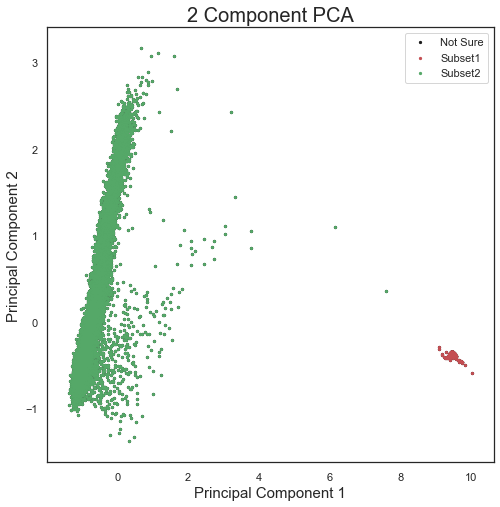

In [40]:
negative_controls = ['JustWater', 'Tube_49']
PC_bead_threshold = 8

bead_df = pd.concat([data_mats[i].copy() for i in negative_controls], axis=0, ignore_index=True)
print("{} records in negative controls".format(bead_df.shape[0]))

real_cols = [i for i in bead_df.columns if i != 'Time']
x = StandardScaler().fit_transform(bead_df[real_cols].values)
pca = PCA(n_components=2, random_state=0)
jb_pca = pca.fit(x)
principalDf = pd.DataFrame(data = jb_pca.transform(x), columns = ['PC1', 'PC2'])

subset1 = list(principalDf.index[principalDf['PC1'] > PC_bead_threshold])
subset2 = list(principalDf.index[principalDf['PC1'] <= PC_bead_threshold])

plt.close('all'), plt.clf()
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)

targets = [subset1, subset2]
labels = ['Subset1', 'Subset2']
colors = ['r', 'g']

ax.scatter(principalDf.loc[:, 'PC1'], principalDf.loc[:, 'PC2'], c='k', label='Not Sure', s = 5)

for target, color, lab in zip(targets, colors, labels):
    _ = ax.scatter(principalDf.loc[target, 'PC1'],
               principalDf.loc[target, 'PC2'], 
               c=color, label=lab, s = 5)

_ =ax.legend()
print("Beads: {}, Noise: {}".format(len(subset1), len(subset2)))

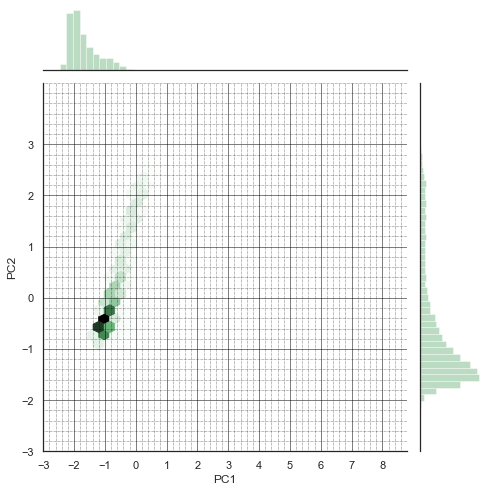

In [41]:
import seaborn as sns; 
sns.set(style="white", color_codes=True)
np.random.seed(0)

joint_kws_=dict(gridsize=25)
g2 = sns.jointplot("PC1", "PC2", data=principalDf.loc[set(principalDf.index) - set(subset1), :],
                   joint_kws=joint_kws_, kind="hex", color="g", height=7, zorder=0)
x_lims_ = g2.ax_joint.get_xlim()
g2.ax_joint.set_xticks(np.arange(round(x_lims_[0]-1), round(x_lims_[1]+1), 1), minor=False)
g2.ax_joint.set_xticks(np.arange(round(x_lims_[0]-1, 1), round(x_lims_[1]+1, 1), 0.2), minor=True)
y_lims_ = g2.ax_joint.get_ylim()
g2.ax_joint.set_yticks(np.arange(round(y_lims_[0]-1), round(y_lims_[1]+1), 1), minor=False)
g2.ax_joint.set_yticks(np.arange(round(y_lims_[0]-1, 1), round(y_lims_[1]+1, 1), 0.2), minor=True)
g2.ax_joint.minorticks_on()
g2.ax_joint.grid(which='major', linestyle='-', linewidth='0.5', color='black')
g2.ax_joint.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [42]:
real_cols = [i for i in bead_df.columns if not i in ['Time', 'FSC-A']]
print(len(subset1), len(subset2))
ss1_thres = bead_df.loc[subset1, real_cols].describe().T[['min', 'max']]
ss2_thres = bead_df.loc[subset2, real_cols].describe([0.00, 0.975]).T.iloc[:, [-4,-2]]
ss2_thres.columns = ['min', 'max']
for rc in real_cols:
    is_ss2_gt_ss1 = ss2_thres.loc[rc, 'min'] > ss1_thres.loc[rc, 'max']
    is_ss1_gt_ss2 = ss1_thres.loc[rc, 'min'] > ss2_thres.loc[rc, 'max']
    print("{}  -- SS1 > SS2: {}, SS2 > SS1: {}".format(rc, is_ss1_gt_ss2, is_ss2_gt_ss1))
    
print(bead_df.min(0))
pd.concat((ss2_thres, ss1_thres), axis=1)

1006 13194
SSC-A  -- SS1 > SS2: True, SS2 > SS1: False
488 530/30-A  -- SS1 > SS2: True, SS2 > SS1: False
488 585/42-A  -- SS1 > SS2: True, SS2 > SS1: False
488 670LP-A  -- SS1 > SS2: True, SS2 > SS1: False
488 780/60-A  -- SS1 > SS2: True, SS2 > SS1: False
633 660/20-A  -- SS1 > SS2: True, SS2 > SS1: False
633 780/60-A  -- SS1 > SS2: True, SS2 > SS1: False
FSC-A          -2007.075562
SSC-A            742.972900
488 530/30-A   -1379.249634
488 585/42-A    -343.244781
488 670LP-A     -447.730164
488 780/60-A    -511.516602
633 660/20-A    -635.094238
633 780/60-A    -647.029480
Time              51.400002
dtype: float32


,min,max,min,max
SSC-A,742.972900,6469.002979,9869.589844,9993.349609
488 530/30-A,-1379.249634,2677.269220,9993.349609,9993.349609
488 585/42-A,-343.244781,151.388123,7677.284668,9964.782227
488 670LP-A,-447.730164,168.843933,7674.007324,9756.228516
488 780/60-A,-511.516602,615.774475,8954.035156,9993.349609
633 660/20-A,-635.094238,366.017395,9993.349609,9993.349609
633 780/60-A,-647.029480,377.995850,9802.409180,9993.349609


[0.79208124 0.11193062]
SSC-A	0.26460111141204834	0.5837855935096741
488 530/30-A	0.27289044857025146	0.6839523911476135
488 585/42-A	0.41710788011550903	-0.02036041021347046
488 670LP-A	0.4153349697589874	-0.21712125837802887
488 780/60-A	0.41800475120544434	-0.06343506276607513
633 660/20-A	0.4092072546482086	-0.2509656548500061
633 780/60-A	0.4084807336330414	-0.27719950675964355
(201634, 2)
[32654, 149324, 4981]


<Figure size 432x288 with 0 Axes>

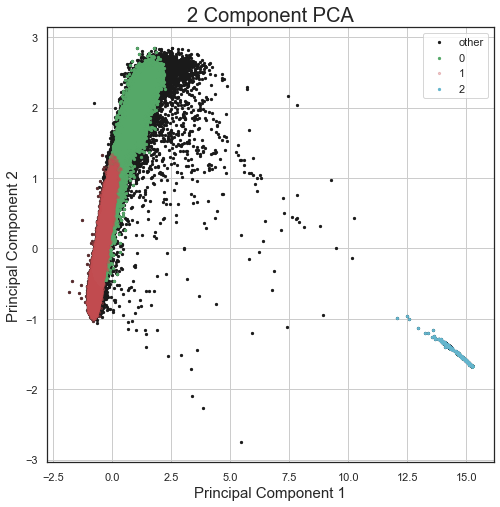

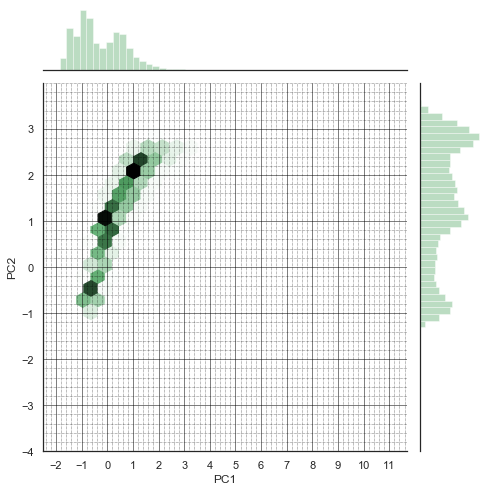

In [57]:
test_pack = ['Tube_10', 'Tube_11', 'Tube_47', 'Tube_6', 'Tube_42']

bnc16_df = pd.concat([data_mats[i] for i in test_pack], ignore_index=True)
bnc16_df = pd.concat([bnc16_df, data_mats['Tube_50'].sample(int(len(bnc16_df)/10))], ignore_index=True)

for col in ss2_thres.index:
    ss2_thres.loc[col, 'min'] = bnc16_df[col].min()

x = StandardScaler().fit_transform(bnc16_df[real_cols].values)
pca2 = PCA(n_components=2, random_state=0)
bnc_pca = pca2.fit(x)
print(bnc_pca.explained_variance_ratio_)
for rc_ in range(len(real_cols)):
    print("{}\t{}\t{}".format(real_cols[rc_], bnc_pca.components_[0, rc_], bnc_pca.components_[1, rc_]))

bnc_pc2_df = pd.DataFrame(data = bnc_pca.transform(x), columns = ['PC1', 'PC2'])

bead_events = list(bnc_pc2_df.index[bnc_pc2_df['PC1'] > 11])
noise_events = filter_w_thresh(bnc16_df[real_cols].copy(), ss2_thres.loc[real_cols, :], ['min', 'max'],  0)

other_events = list(set(bnc_pc2_df.index) - set(noise_events) - set(bead_events))
other_events = set(other_events).intersection(set(bnc_pc2_df.index[(bnc_pc2_df['PC1'] > 0) & 
                                                                   (bnc_pc2_df['PC2'] > 0.8) ]))

noise_lim = bnc16_df.loc[noise_events, real_cols].describe([0.0, 1.00]).T.iloc[:, [-4,-2]]
cell_lim = bnc16_df.loc[other_events, real_cols].describe([0.05, 0.95]).T.iloc[:, [-4,-2]]
bead_lim = bnc16_df.loc[bead_events, real_cols].describe([0.00, 1.0]).T.iloc[:, [-4,-2]]

noise_lim.columns = ['Noise_min', 'Noise_max']
bead_lim.columns = ['Bead_min', 'Bead_max']
cell_lim.columns = ['Cell_min', 'Cell_max']

#blue_chan = [i for i in cell_lim.index if '488 ' in i]
#cell_lim.loc[blue_chan, 'Cell_min'] = cell_lim.loc[blue_chan, 'Cell_min']*.2
#cell_lim.loc['SSC-A', 'Cell_min'] = noise_lim.loc['SSC-A', 'Noise_min']

cell_events = filter_w_thresh(bnc16_df[real_cols].copy(), cell_lim.loc[real_cols, :], ['Cell_min', 'Cell_max'],  0)

print(bnc_pc2_df.shape)

targets = [cell_events, noise_events, bead_events]
print([len(i) for i in targets])
labels = ['0', '1', '2']
colors = ['g', 'r', 'c']
alphas = [1, 0.3, 1.0]

plt.close('all'), plt.clf()
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)
ax.scatter(bnc_pc2_df.loc[:, 'PC1'], 
           bnc_pc2_df.loc[:, 'PC2'], 
           c='k', label='other', s=5)

for target, color, lab, alpha_ in zip(targets, colors, labels, alphas):
    ax.scatter(bnc_pc2_df.loc[target, 'PC1'],
               bnc_pc2_df.loc[target, 'PC2'], 
               c=color, label=lab, s = 5, alpha=alpha_)
ax.legend()
ax.grid()

ss_mix = pd.concat((noise_lim, cell_lim, bead_lim), sort=True, axis=1)


joint_kws_=dict(gridsize=20)
gg = sns.jointplot("PC1", "PC2", data=bnc_pc2_df.loc[set(bnc_pc2_df.index) - set(bead_events) - set(noise_events), :],
                   joint_kws=joint_kws_, kind="hex", color="g", height=7, zorder=0)
x_lims_ = gg.ax_joint.get_xlim()
gg.ax_joint.set_xticks(np.arange(round(x_lims_[0]-1), round(x_lims_[1]+1), 1), minor=False)
gg.ax_joint.set_xticks(np.arange(round(x_lims_[0]-1, 1), round(x_lims_[1]+1, 1), 0.2), minor=True)
y_lims_ = gg.ax_joint.get_ylim()
gg.ax_joint.set_yticks(np.arange(round(y_lims_[0]-1), round(y_lims_[1]+1), 1), minor=False)
gg.ax_joint.set_yticks(np.arange(round(y_lims_[0]-1, 1), round(y_lims_[1]+1, 1), 0.2), minor=True)
gg.ax_joint.minorticks_on()
gg.ax_joint.grid(which='major', linestyle='-', linewidth='0.5', color='black')
gg.ax_joint.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [90]:
ss_mix_2 = ss_mix.astype(int).copy()
ss_mix_2.loc[['488 530/30-A', '488 585/42-A'], 'Cell_min'] = [1300, 55]
ss_mix_2.loc[['488 530/30-A', '488 585/42-A'], 'Noise_max'] = [1300-1, 55-1]
outfile2 = os.path.join("/Volumes/KeithSSD/RockCreek/RC_CellCounts/data/Batch_Summaries", batch_date+".gains.txt")
ss_mix_2['gains'] = pd.Series({i:gain_dict[i.replace('-A', " gain")] for i in ss_mix_2.index})
ss_mix_2.to_csv(outfile2, sep="\t")
ss_mix_3 = pd.read_csv("/Volumes/KeithSSD/RockCreek/RC_CellCounts/data/Batch_Summaries/gate_limits.txt", sep="\t", index_col=0)
fl_channels = ['488 585/42-A', '488 670LP-A', '488 780/60-A', '633 660/20-A', '633 780/60-A']
ss_mix_2.loc[fl_channels, 'Cell_max'] = ss_mix_3.loc[fl_channels, 'Cell_max']
ss_mix_2

,Noise_min,Noise_max,Cell_min,Cell_max,Bead_min,Bead_max,gains
488 530/30-A,-1734,1299,1300,9781,9993,9993,625
488 585/42-A,-459,54,55,3820,6544,9993,425
488 670LP-A,-650,168,-69,1052,6420,9993,425
488 780/60-A,-898,615,-69,4149,7800,9993,637
633 660/20-A,-986,366,-228,2092,9883,9993,695
633 780/60-A,-1304,377,-300,772,8906,9993,616
SSC-A,633,6468,1850,8581,9017,9993,525


In [91]:
ss_mix_3

,Noise_min,Noise_max,Cell_min,Cell_max,Bead_min,Bead_max,gains
488 530/30-A,-1593,5257,4767,9993,9993,9993,625
488 585/42-A,-459,186,11,3820,6544,9993,425
488 670LP-A,-650,221,40,1052,6420,9993,425
488 780/60-A,-898,1520,46,4149,7800,9993,637
633 660/20-A,-1328,479,-288,2092,9883,9993,695
633 780/60-A,-1304,455,-360,772,8906,9993,616
SSC-A,633,7060,1030,9627,9017,9993,525


In [92]:
fixative_dilution = 0.2 # mL added to the original sample 
bead_concentration = 1e6 # beads per mL
bead_volume = 0.05 # mL
cells_volume = 0.5 # mL 
ratio_multiplier = ((bead_concentration*bead_volume)/(cells_volume))/fixative_dilution

all_count_df = file_table3.copy()
new_columns = ['runtime', 'beads', 'cells', 'noise', 'concentration', 'noise_rate']
for nc in new_columns:
    all_count_df[nc] = pd.Series(index=all_count_df.index)

for tube_n, bnci_df in data_mats.items():
    beadi_events = filter_w_thresh(bnci_df.copy(), bead_lim, ['Bead_min', 'Bead_max'], 0)
    noisei_events = filter_w_thresh(bnci_df.copy(), ss_mix_2, ['Noise_min', 'Noise_max'], 0)
    celli_events = filter_w_thresh(bnci_df.copy(), ss_mix_2, ['Cell_min', 'Cell_max'], 0)

    all_count_df.loc[tube_n, ['beads', 'cells', 'noise']] = [len(beadi_events), 
                                                             len(set(celli_events) - set(beadi_events)), 
                                                             len(noisei_events)]
    all_count_df.loc[tube_n, 'runtime'] = (bnci_df.Time.max() - bnci_df.Time.min())/100
    print(all_count_df.loc[tube_n, 'cells'])
    
# cells/bead * beads/mL = cells/mL
all_count_df['concentration'] = (all_count_df['cells'] /(all_count_df['beads']+1))*ratio_multiplier
all_count_df['noise_conc'] = (all_count_df['noise'] /(all_count_df['beads']+1))*ratio_multiplier
all_count_df['bead_rate'] = (all_count_df['beads'] /(all_count_df['runtime']+1))


8.0
440.0
2621.0
365.0
2516.0
90.0
120.0
2675.0
18.0
9.0
141.0
561.0
126.0
3.0
73.0
52.0
14.0
79.0
43.0
86.0
134.0
77.0
68.0
1314.0
5842.0
321.0
1230.0
15.0
525.0
232.0
32.0
106.0
2644.0
125.0
432.0
310.0
159.0
449.0
205.0
111.0
281.0
536.0
276.0
76.0
389.0
47.0
849.0
156.0
1083.0
216.0
125.0
602290.0


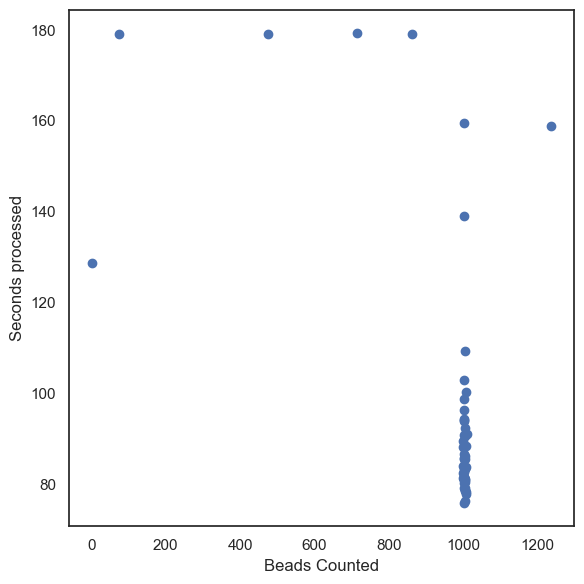

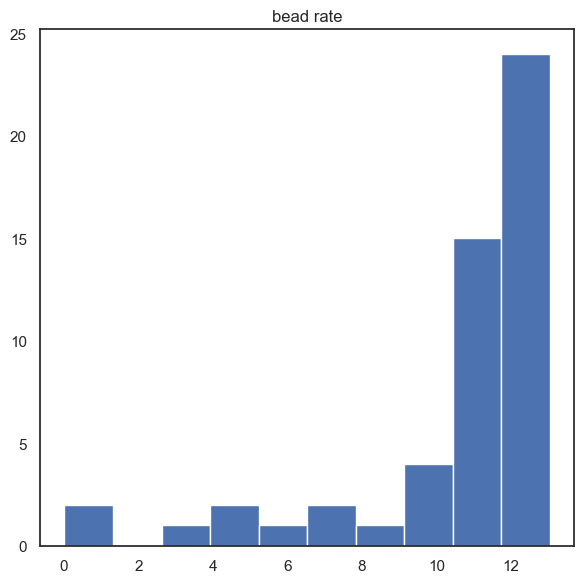

,proc_date,fileName,pathName,proc_datetime,FSC gain,SSC gain,488 530/30 gain,488 585/42 gain,488 670LP gain,488 780/60 gain,...,startTime,endTime,runtime,beads,cells,noise,concentration,noise_rate,noise_conc,bead_rate
JustWater,02-07-20,02_07_20_JustWater.fcs,/Volumes/KeithSSD/RockCreek/RC_CellCounts/data...,2020-02-07,325,525,625,425,425,637,...,19:04:38,19:06:48,128.650000,2.0,8.0,7364.0,1.333333e+06,NaN,1.227333e+09,0.015426
Tube_11,02-07-20,02_07_20_Tube_11.fcs,/Volumes/KeithSSD/RockCreek/RC_CellCounts/data...,2020-02-07,325,525,625,425,425,637,...,17:05:57,17:08:58,179.234004,715.0,126.0,17253.0,8.798883e+04,NaN,1.204818e+07,3.967065
Tube_14,02-07-20,02_07_20_Tube_14.fcs,/Volumes/KeithSSD/RockCreek/RC_CellCounts/data...,2020-02-07,325,525,625,425,425,637,...,17:15:44,17:18:45,179.144004,475.0,52.0,15443.0,5.462185e+04,NaN,1.622164e+07,2.636779
Tube_3,02-07-20,02_07_20_Tube_3.fcs,/Volumes/KeithSSD/RockCreek/RC_CellCounts/data...,2020-02-07,325,525,625,425,425,637,...,16:34:01,16:37:02,179.025000,73.0,365.0,21623.0,2.466216e+06,NaN,1.461014e+08,0.405499
Tube_4,02-07-20,02_07_20_Tube_4.fcs,/Volumes/KeithSSD/RockCreek/RC_CellCounts/data...,2020-02-07,325,525,625,425,425,637,...,16:40:23,16:43:04,159.548008,1003.0,2516.0,26188.0,1.252988e+06,NaN,1.304183e+07,6.247353
Tube_47,02-07-20,02_07_20_Tube_47.fcs,/Volumes/KeithSSD/RockCreek/RC_CellCounts/data...,2020-02-07,325,525,625,425,425,637,...,18:42:16,18:44:57,158.809004,1237.0,1083.0,39910.0,4.373990e+05,NaN,1.611874e+07,7.740490
Tube_7,02-07-20,02_07_20_Tube_7.fcs,/Volumes/KeithSSD/RockCreek/RC_CellCounts/data...,2020-02-07,325,525,625,425,425,637,...,16:51:13,16:53:34,139.165996,1004.0,2675.0,9893.0,1.330846e+06,NaN,4.921891e+06,7.162936
Tube_8_R1,02-07-20,02_07_20_Tube_8_R1.fcs,/Volumes/KeithSSD/RockCreek/RC_CellCounts/data...,2020-02-07,325,525,625,425,425,637,...,16:54:45,16:57:46,179.100996,862.0,18.0,7284.0,1.042874e+04,NaN,4.220162e+06,4.786203


In [93]:
###### print(all_count_df[['beads', 'runtime']].describe())
fig5, ax5 = plt.subplots(nrows=1, ncols=1, figsize=(6,6), num=5, dpi=100)
ax5.scatter(all_count_df['beads'].values, all_count_df['runtime'], marker='o')
ax5.set(ylabel='Seconds processed', xlabel='Beads Counted');
plt.tight_layout()

fig6, ax6 = plt.subplots(nrows=1, ncols=1, figsize=(6,6), num=6, dpi=100)
ax6.hist(all_count_df['bead_rate'])
ax6.set_title('bead rate')
plt.tight_layout()
plt.show()

clean_counts = all_count_df.copy()[(all_count_df['beads'] > 800) & (all_count_df['bead_rate'] > 5)]
all_count_df.loc[( (all_count_df['bead_rate'] < 9) | (all_count_df['beads'] < 800) | (all_count_df['beads'] > 1025)) | (all_count_df['runtime'] < 50) , :]

[6748, 199577, 3474]


<Figure size 432x288 with 0 Axes>

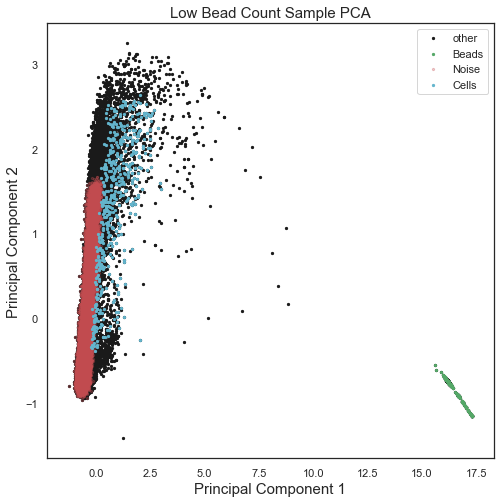

In [94]:
check_sample2 = pd.concat([data_mats[i] for i in ['JustWater', 'Tube_11', 'Tube_14', 'Tube_3', 'Tube_47',
                                                  'Tube_10', 'Tube_47', 'Tube_6', 'Tube_42']], ignore_index=True)

pca2 = PCA(n_components=2, random_state=0)
x = StandardScaler().fit_transform(check_sample2[real_cols].values)
cs_pca = pca2.fit(x)
cs_pc2_df = pd.DataFrame(data = cs_pca.transform(x), columns = ['PC1', 'PC2'])

bead_cs_v2 = filter_w_thresh(check_sample2.copy(), bead_lim, ['Bead_min', 'Bead_max'], 0)
noise_cs_v2 = filter_w_thresh(check_sample2.copy(), ss_mix_2, ['Noise_min', 'Noise_max'], 0) 
cells_cs_v2 = filter_w_thresh(check_sample2.copy(), ss_mix_2, ['Cell_min', 'Cell_max'], 0)
cells_cs_v2 = list(set(cells_cs_v2) - set(noise_cs_v2))

assert len(set(bead_cs_v2).intersection(set(noise_cs_v2))) == 0
assert len(set(noise_cs_v2).intersection(set(cells_cs_v2))) == 0
assert len(set(bead_cs_v2).intersection(set(cells_cs_v2))) == 0

targets = [bead_cs_v2, noise_cs_v2, cells_cs_v2]
print([len(i) for i in targets])
labels = ['Beads', 'Noise', 'Cells']
colors = ['g', 'r', 'c']
alphas = [1, 0.3, 1.0]

plt.close('all'), plt.clf()
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Low Bead Count Sample PCA', fontsize = 15)
xtpytp = cs_pc2_df[['PC1', 'PC2']].sample(50000)
ax.scatter(xtpytp['PC1'], xtpytp['PC2'], c='k', label='other', s=5)

for target, color, lab, alpha_ in zip(targets, colors, labels, alphas):
    subtarg = set(target).intersection(set(xtpytp.index))
    ax.scatter(xtpytp.loc[subtarg, 'PC1'],
               xtpytp.loc[subtarg, 'PC2'], 
               c=color, label=lab, s = 5, alpha=alpha_)
ax.legend()
plt.show()

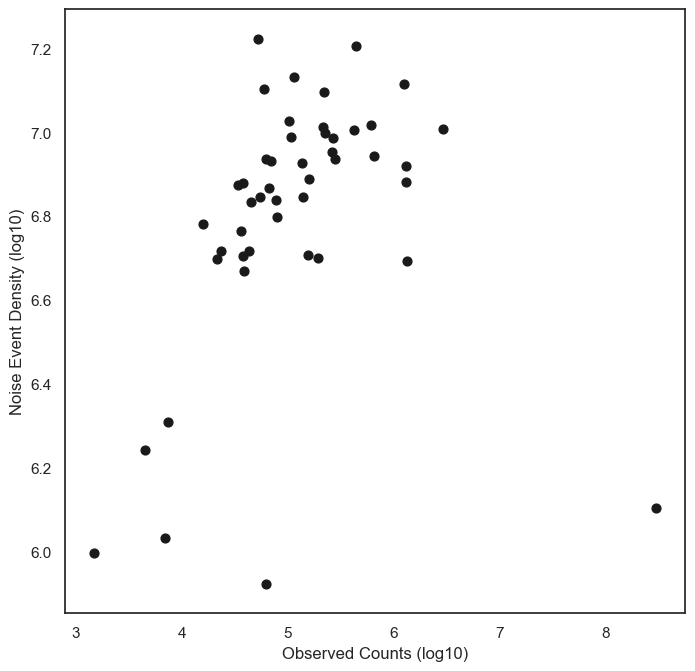

,data_index,Sample Date,Sample Depth,Sample Time,Sample Station,conc_int,log-noise
143,Tube_12,2019-07-29,END BLANK,PM,NaN,1488,5.994581
117,Tube_8_R2,2019-07-26,START BLANK,NaN,NaN,4482,6.242667
142,Tube_15,2019-07-29,START BLANK,NaN,NaN,6951,6.032200
96,Tube_26,2019-07-24,END BLANK,PM,NaN,7470,6.308960
0,Tube_29,2019-07-08,TOP,PM,A,15936,6.782170
145,Tube_17,2019-07-29,BOTTOM,AM,RC1,21393,6.697195
30,Tube_44,2019-07-10,END BLANK,NaN,NaN,23406,6.716519
159,Tube_21,2019-07-29,BOTTOM,AM,RC9,33797,6.873331
151,Tube_13,2019-07-29,BOTTOM,PM,RC2,36390,6.764479
98,Tube_42,2019-07-24,BOTTOM,AM,RC1,37810,6.880216


In [95]:
clean_counts['log-noise'] = clean_counts['noise_conc'].apply(lambda x: np.log10(x) if x > 0 else 0)
clean_counts['log-conc'] = clean_counts['concentration'].apply(lambda x: np.log10(x) if x > 0 else 0)

for nc in ['log-conc','log-noise', 'concentration', 'proc_datetime']:
    exp_cnt_df[nc] = pd.Series(index=exp_cnt_df.index)    
    for ix in exp_cnt_df.index[exp_cnt_df['data_index'].notnull()]:
        cc_ix = exp_cnt_df.loc[ix, 'data_index']
        if cc_ix in list(clean_counts.index):
            exp_cnt_df.loc[ix, nc] = clean_counts.loc[cc_ix, nc]
        
# plot log-exp (x) against log-conc (y)
# sybr gets green, pi gets red
# f / uf pairs get numbers 
exp_cnt_df_plt = exp_cnt_df.copy()[exp_cnt_df[['log-conc', 'log-noise']].isnull().sum(1) == 0]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8), num=1, dpi=100)
ax.scatter(exp_cnt_df_plt['log-conc'], exp_cnt_df_plt['log-noise'], s=160, c='k', marker='.')
ax.set(ylabel='Noise Event Density (log10)', xlabel='Observed Counts (log10)');
plt.show()

clean_counts['conc_int'] = clean_counts['concentration'].astype(int)
exp_cnt_df_plt['conc_int'] = exp_cnt_df_plt['concentration'].astype(int)
exp_cnt_df_plt.loc[:, ['data_index'] + exp_cols + ['conc_int', 'log-noise']].sort_values(by='conc_int')


In [96]:
outfile = os.path.join("/Volumes/KeithSSD/RockCreek/RC_CellCounts/data/Batch_Summaries", batch_date+".txt")
exp_cnt_df_plt.to_csv(outfile, sep="\t", index=False)
print(exp_cnt_df_plt.shape)
print(exp_cnt_df_plt.columns)

(47, 17)
Index(['Prefilter-Date', 'Tube', 'Sample Date', 'Sample Time', 'Sample Depth',
       'Sample Station', 'Notes', 'Processing Speed', 'Notes.1', 'Check',
       'Tube_fmt', 'data_index', 'log-conc', 'log-noise', 'concentration',
       'proc_datetime', 'conc_int'],
      dtype='object')


In [97]:
exp_cnt_df_plt[['data_index', 'conc_int' , 'Tube']+exp_cols].sort_values(by='conc_int')

,data_index,conc_int,Tube,Sample Date,Sample Depth,Sample Time,Sample Station
143,Tube_12,1488,12.0,2019-07-29,END BLANK,PM,NaN
117,Tube_8_R2,4482,8.0,2019-07-26,START BLANK,NaN,NaN
142,Tube_15,6951,15.0,2019-07-29,START BLANK,NaN,NaN
96,Tube_26,7470,26.0,2019-07-24,END BLANK,PM,NaN
0,Tube_29,15936,29.0,2019-07-08,TOP,PM,A
145,Tube_17,21393,17.0,2019-07-29,BOTTOM,AM,RC1
30,Tube_44,23406,44.0,2019-07-10,END BLANK,NaN,NaN
159,Tube_21,33797,21.0,2019-07-29,BOTTOM,AM,RC9
151,Tube_13,36390,13.0,2019-07-29,BOTTOM,PM,RC2
98,Tube_42,37810,42.0,2019-07-24,BOTTOM,AM,RC1
